# 用户画像 

人们常说移动互联网的运营已经进入了下半场，几乎所有的企业都希望能用更优质的产品和更精准的服务留住用户，这就需要制定出合适的获客策略。而要做到这一点，前提就是为用户精准画像，也就是根据用户的人口统计信息和消费行为数据，给用户分组，然后推测出用户的消费习惯和价值高低。

## 定义问题

RFM（Recency、Frequency、Monetary ），它是用户画像的衍生品，也是目前很多互联网厂商普遍采用的分析方式。具体来看：
- R 是新进度，代表自用户上次消费以来的天数。这个指标其实也就是用户的热乎度，比如说上次使用 App 是一个月前，R 值就是 30。如果今天又用了一次 App，那 R 值就会立刻被更新为 1；
- F 是消费频率，代表用户是否频繁使用服务。这也是用户黏性的风向标；
- M 是消费金额，代表用户在一段时间内消费的总金额。

简单来说就是，只要我们从用户的基本信息和消费行为数据中求出每位用户的 R、F、M 的值，就可以根据它对用户分组画像了，这就好像给用户贴上了一堆数字化的标签。

项目整体上可以分为两个阶段：第一个阶段是求出 RFM 值，第二个阶段就是利用 RFM 值，给用户分组画像，进而绘制出高价值、中等价值和低价值用户的分布情况。


---
## 数据预处理

### 导入数据

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df_sales = pd.read_csv('../res/flower-express-order.csv', encoding='utf-8')
df_sales.head()

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


### 数据可视化

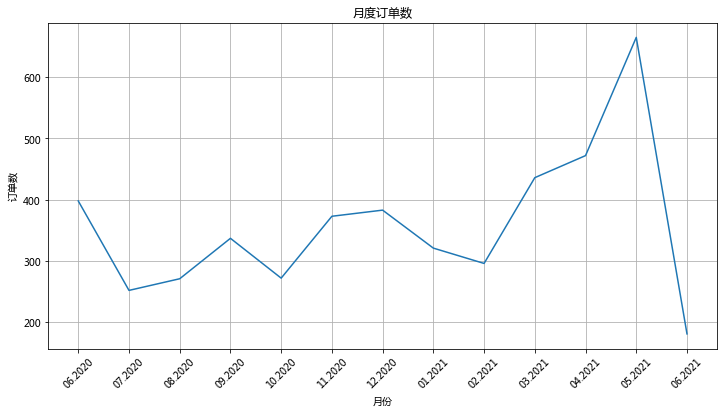

In [2]:
# 构建月度的订单数的DataFrame
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('M').nunique()
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份')
ax.set_ylabel('订单数')
ax.set_title('月度订单数')

# 设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show()

In [3]:
?plt.xticks

Signature: plt.xticks(ticks=None, labels=None, **kwargs)
Docstring:
Get or set the current tick locations and labels of the x-axis.

Pass no arguments to return the current values without modifying them.

Parameters
----------
ticks : array-like, optional
    The list of xtick locations.  Passing an empty list removes all xticks.
labels : array-like, optional
    The labels to place at the given *ticks* locations.  This argument can
    only be passed if *ticks* is passed as well.
**kwargs
    `.Text` properties can be used to control the appearance of the labels.

Returns
-------
locs
    The list of xtick locations.
labels
    The list of xlabel `.Text` objects.

Notes
-----
Calling this function with no arguments (e.g. ``xticks()``) is the pyplot
equivalent of calling `~.Axes.get_xticks` and `~.Axes.get_xticklabels` on
the current axes.
Calling this function with arguments is the pyplot equivalent of calling
`~.Axes.set_xticks` and `~.Axes.set_xticklabels` on the current axes.

Exam

### 数据清洗

In [4]:
df_sales.isna().sum()

订单号     0
产品码     0
消费日期    0
产品说明    0
数量      0
单价      0
用户码     0
城市      0
dtype: int64

In [5]:
df_sales = df_sales.drop_duplicates()

**查看数据的统计信息，发现数据异常**

In [6]:
df_sales.describe()

,数量,单价,用户码
count,85920.000000,85920.000000,85920.000000
mean,10.115747,3.599711,15338.080389
std,49.114285,134.410498,391.309086
min,-9360.000000,0.000000,14681.000000
25%,2.000000,1.250000,15022.000000
50%,4.000000,1.950000,15334.000000
75%,12.000000,3.750000,15673.000000
max,3114.000000,38970.000000,16019.000000


发现一些异常数据，比如数量的最小值居然是负值。

进一步清洗数据

In [7]:
df_sales = df_sales.loc[df_sales['数量'] > 0]

### 特征工程

#### 计算每订单的总价

In [8]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价']
df_sales.head()

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


#### 构建用户表

In [9]:
df_user = pd.DataFrame(df_sales['用户码'].unique())
df_user.columns = ['用户码']
df_user = df_user.sort_values(by='用户码', ascending=True).reset_index(drop=True)
df_user

,用户码
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


reset_index(drop=True) 的意思是重置索引，生成新的默认数值类型索引，并且不保留原来的索引。

#### 求 R 值

使用最新时间 - 最近一次消费时间。R值越大，说明用户处于休眠态，很可能已经被别的购物平台所吸引了，也就是流失了。

In [10]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
# 找出每个用户的最近一条消费记录
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index()
df_recent_buy.columns = ['用户码','最近日期']
# 计算最新日期与用户最近一次消费日期的天数: timedelta.days
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days
# df_recent_buy
# 合并最近一条消费记录到 df_user
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码')
df_user.head()

,用户码,R值
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7


#### 求 F 值

每个用户的消费次数


In [11]:
df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index()
df_frequency.columns = ['用户码','F值']
# 把消费频率整合至df_user结构
df_user = pd.merge(df_user, df_frequency, on='用户码')
df_user.head()

,用户码,R值,F值
0,14681,70,7
1,14682,187,2
2,14684,25,390
3,14687,106,15
4,14688,7,324


#### 求 M 值

用户消费的总和。

In [12]:
df_revenue = df_sales.groupby('用户码').总价.sum().reset_index()
df_revenue.columns = ['用户码','M值']
# 把消费金额整合至df_user结构
df_user = pd.merge(df_user, df_revenue, on='用户码')
df_user.head()

,用户码,R值,F值,M值
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,324,5579.10


#### 显示R、F、M值的分布情况

- 新进度：R值

<AxesSubplot:title={'center':'新进度分布直方图'}, ylabel='Frequency'>

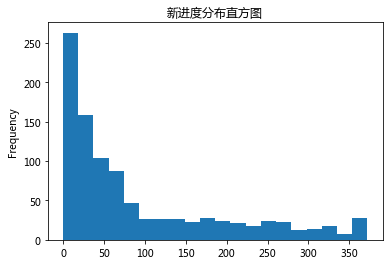

In [13]:
df_user['R值'].plot(kind='hist', bins=20, title = '新进度分布直方图')

- 消费频率：F值

<AxesSubplot:title={'center':'消费频率分布直方图'}, ylabel='Frequency'>

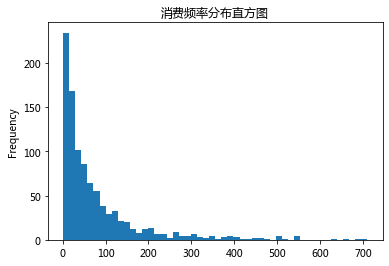

In [14]:
df_user.query('F值 < 800')['F值'].plot(kind='hist', bins=50, title='消费频率分布直方图')

- 消费金额：M值

<AxesSubplot:title={'center':'消费金额分布直方图'}, ylabel='Frequency'>

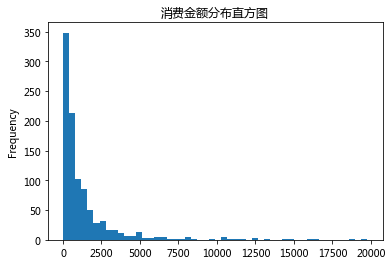

In [15]:
df_user.query('M值 < 20000')['M值'].plot(kind='hist', bins=50, title='消费金额分布直方图')

---
## 选择算法和建立模型

我们要搞清楚，给用户做分组画像属于监督学习问题，还是无监督学习问题？我们要通过历史订单数据来给用户分组，这是没有任何已知标签可以做参照的，数据集中并没有一个字段指明用户的价值是“高”还是“低”，所以这显然是一个无监督学习问题。

在无监督学习中，聚类和降维是两种最常见的算法：

- 聚类：主要可以用来做分组；
- 降维：则是通过数学变换，将原始高维属性空间转变为一个低维“子空间”，它本质上是通过最主要的几个特征维度实现对数据的描述。

聚类算法可以让机器把数据集中的样本按照特征的性质分组，不过它只是帮我们把**数据特征彼此邻近**的用户聚成一组（这里的组称为聚类的簇）。“特征彼此邻近”，指的这些用户的数据特征在坐标系中有更短的向量空间距离。

聚类算法有多种，这里我直接选用 K-Means（K- 均值）算法了，因为这个算法不仅简洁，而且效率也高，是我们最常用的聚类算法。像文档归类、欺诈行为检测、用户分组等等这些场景，我们往往都能用到。

### K-Means

在 K-Means 算法中，“K”是一个关键。K 代表聚类的簇（也就是组）的个数。
指定 K 的数值后，K-Means 算法会在数据中随机挑选出 K 个数据点，作为簇的质心（centroid），这些质心就是未来每一个簇的中心点，算法会根据其它数据点和它的距离来进行聚类。
挑选出质心后，K-Means 算法会遍历每一个数据点，计算它们与每一个质心的距离（比如欧式距离）。数据点离哪个质心近，就跟哪个质心属于一类。

在整个聚类过程中，为了选择出更好的质心，“挑选质心”和“遍历数据点与质心的距离”会不断重复，直到质心的移动变化很小了，或者说固定不变了，那 K-Means 算法就可以停止了。

### 手肘法选取 K 值

在事先并不是很确定分成多少组比较合适的情况下，“手肘法”（elbow method）可以帮我们决定，在某一批数据点中，数据分为多少组比较合适。

手肘法是通过聚类算法的损失值曲线来直观确定簇的数量。


In [16]:
from sklearn.cluster import KMeans

def show_elbow(df):
    # 聚质心的距离（损失）
    distance_list = []
    # K值范围
    K = range(1,9)
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100)
        kmeans = kmeans.fit(df)
        #  添加每个K值的损失
        distance_list.append(kmeans.inertia_)

    plt.plot(K, distance_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('距离均方误差')
    plt.title('k值手肘图')

显示R值聚类K值手肘图

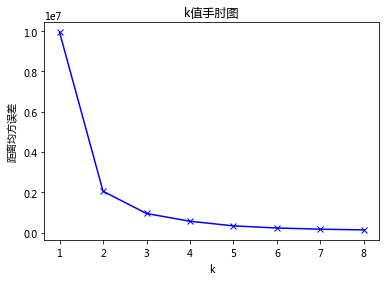

In [17]:
show_elbow(df_user[['R值']])

显示F值聚类K值手肘图

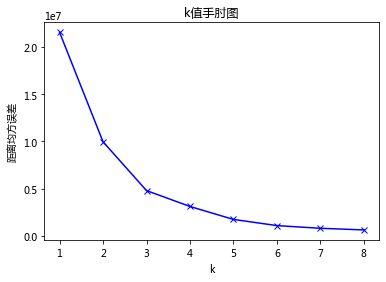

In [18]:
show_elbow(df_user[['F值']])

显示M值聚类K值手肘图

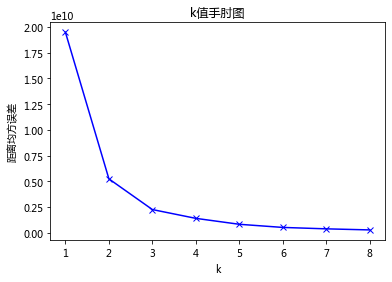

In [19]:
show_elbow(df_user[['M值']])

### 创建模型

从上图可以看到，R、F、M 值的拐点大概都在 2 到 4 之间附近，这就意味着我们把用户分成 2、3、4 个组都行。这里我选择 3 作为 R 值的簇的个数，选择 4 作为 F 值的簇的个数，选择 3 作为 M 值的簇的个数。


In [20]:
kmeans_R = KMeans(n_clusters=3)
kmeans_F = KMeans(n_clusters=4)
kmeans_M = KMeans(n_clusters=4)

---
## 训练模型


In [21]:
# 拟合模型
kmeans_R.fit(df_user[['R值']])
kmeans_F.fit(df_user[['F值']])
kmeans_M.fit(df_user[['M值']])

KMeans(n_clusters=4)

#### 给 R、F、M 值聚类

- 通过聚类模型求出R值的层级

In [22]:
df_user['R值层级'] = kmeans_R.predict(df_user[['R值']])
df_user.head()

,用户码,R值,F值,M值,R值层级
0,14681,70,7,498.95,0
1,14682,187,2,52.00,2
2,14684,25,390,1201.51,0
3,14687,106,15,628.38,2
4,14688,7,324,5579.10,0


- 观察 R值层级 统计信息

In [23]:
df_user.groupby('R值层级')['R值'].describe()

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0
1,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
2,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0


发现 R值层级的统计信息，没有按照 R值 排序。

原因是“聚类”，作为一种无监督学习算法，是不知道顺序的重要性的，它只是盲目地把用户分群（按照其空间距离的临近性），而不管每个群的具体意义，因此也就没有排序的功能。

- 进一步加工

**定义一个order_cluster函数为聚类排序**

In [24]:
def order_cluster(cluster_name, target_name, df, ascending=False):
    '''
    为聚类排序
    sample: order_cluster('R值层级', 'R值', df_user, False)
    '''
    new_cluster_name = 'new_' + cluster_name
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_name, ascending=ascending).reset_index(drop=True)
    # ？创建索引字段
    df_new['index'] = df_new.index
    # 基于 聚类名称 把 df_new 还原为 df 对象，并添加索引字段
    df_new = pd.merge(df, df_new[[cluster_name,'index']], on=cluster_name)
    # 删除聚类名称
    df_new = df_new.drop([cluster_name], axis=1)
    # 将索引字段重命名为聚类名称字段
    df_new = df_new.rename(columns={"index":cluster_name})

    return df_new

- 重新计算 R值、F值、M值层级

In [25]:
# 调用簇排序函数
df_user = order_cluster('R值层级', 'R值', df_user, False)
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True)
df_user.head()

,用户码,R值,F值,M值,R值层级
0,14681,70,7,498.95,2
1,14682,187,2,52.00,1
2,14684,25,390,1201.51,2
3,14687,106,15,628.38,1
4,14688,7,324,5579.10,2


In [26]:
df_user.groupby('R值层级')['R值'].describe()

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
1,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0
2,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0


In [27]:
df_user['F值层级'] = kmeans_F.predict(df_user[['F值']])

# 调用簇排序函数
df_user = order_cluster('F值层级', 'F值', df_user, True)
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True)
# df_user.head()
df_user.groupby('F值层级')['F值'].describe()

,count,mean,std,min,25%,50%,75%,max
F值层级,,,,,,,,
0,720.0,32.277778,24.128263,1.0,12.00,27.0,48.25,92.0
1,203.0,152.960591,50.338738,93.0,113.50,138.0,191.50,279.0
2,50.0,417.080000,109.618232,289.0,329.75,390.0,492.50,710.0
3,7.0,1281.000000,515.121345,887.0,996.50,1112.0,1304.50,2366.0


In [28]:
df_user['M值层级'] = kmeans_M.predict(df_user[['M值']])

# 调用簇排序函数
df_user = order_cluster('M值层级', 'M值', df_user, True)
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True)
# df_user.head()
df_user.groupby('M值层级')['M值'].describe()

,count,mean,std,min,25%,50%,75%,max
M值层级,,,,,,,,
0,803.0,642.261359,497.413272,6.20,254.105,471.40,948.500,2085.33
1,143.0,3554.556573,1293.186077,2100.60,2520.965,3189.81,4368.835,7354.62
2,27.0,11434.159259,3399.310286,7616.53,8242.110,10484.99,12870.455,19766.59
3,7.0,46663.441429,10484.139456,33643.08,38523.550,44534.30,55393.430,60632.75


#### 计算每个用户 RFM 总分

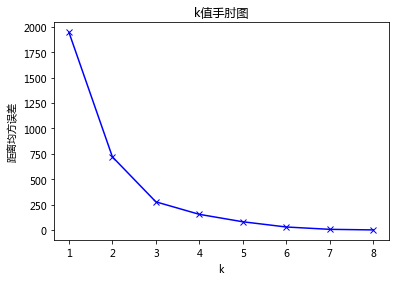

In [29]:
df_user['总分'] = df_user['R值层级'] + df_user['F值层级'] + df_user['M值层级']
# df_user

# 总分的手肘图
show_elbow(df_user[['总分']])


#### 根据 RFM总分手肘图，标记用户

In [30]:
# 0-2 分，低价值用户
# 3-4 分，中价值用户
# 5-8 分，高价值用户

df_user.loc[(df_user['总分']<=2) & (df_user['总分']>=0), '总体价值'] = '低价值' 
df_user.loc[(df_user['总分']<=4) & (df_user['总分']>=3), '总体价值'] = '中价值' 
df_user.loc[(df_user['总分']<=8) & (df_user['总分']>=5), '总体价值'] = '高价值'
df_user

,用户码,R值,F值,M值,R值层级,F值层级,M值层级,总分,总体价值
0,14681,70,7,498.95,2,0,0,2,低价值
1,14682,187,2,52.00,1,0,0,1,低价值
2,14684,25,390,1201.51,2,2,0,4,中价值
3,14687,106,15,628.38,1,0,0,1,低价值
4,14688,7,324,5579.10,2,2,1,5,高价值
...,...,...,...,...,...,...,...,...,...
975,16015,3,181,704.55,2,1,0,3,中价值
976,16016,2,224,1465.51,2,1,0,3,中价值
977,16017,46,32,211.88,2,0,0,2,低价值
978,16018,38,28,408.90,2,0,0,2,低价值


### 用户分组可视化

显示高、中、低价值组分布散点图

Text(0, 0.5, 'R值')

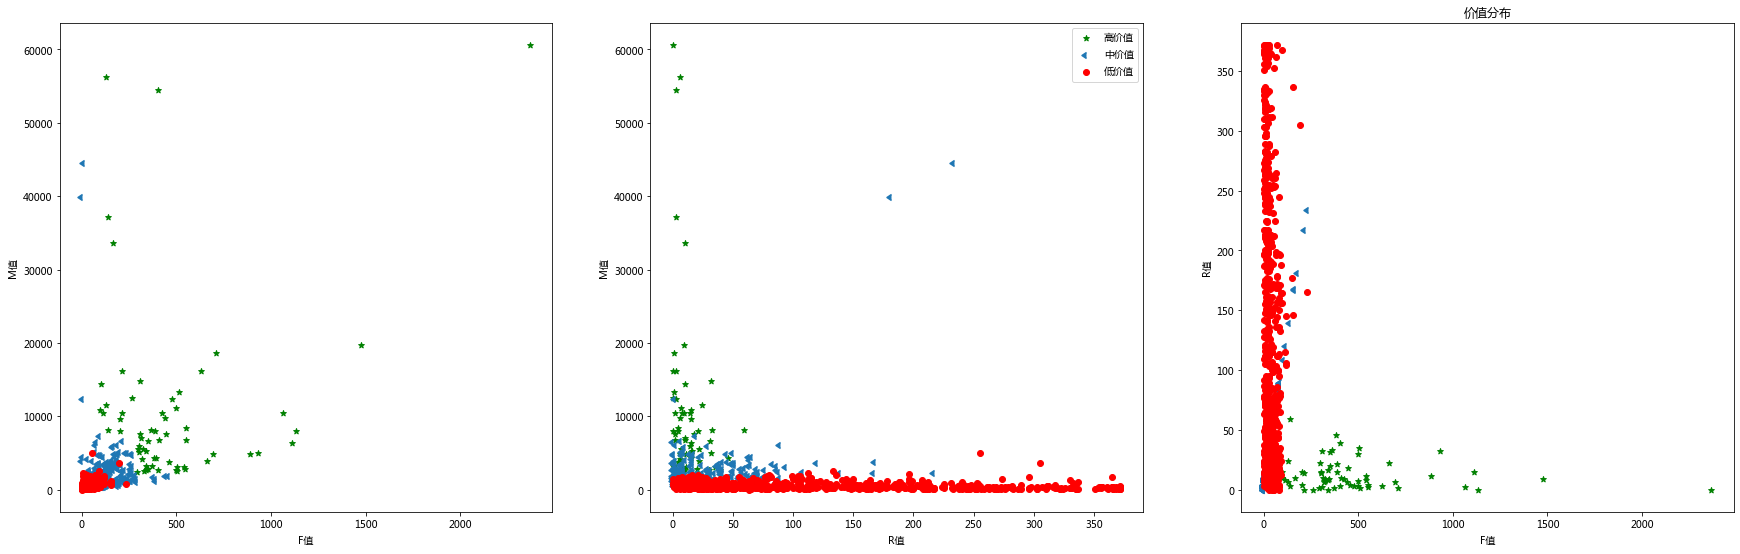

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30, 9))
plt.title('价值分布')

# F值 vs M值
axes[0].scatter(df_user.query("总体价值 == '高价值'")['F值'],
                df_user.query("总体价值 == '高价值'")['M值'], c='g',marker='*', label='高价值')
axes[0].scatter(df_user.query("总体价值 == '中价值'")['F值'],
                df_user.query("总体价值 == '中价值'")['M值'],marker=8, label='中价值')
axes[0].scatter(df_user.query("总体价值 == '低价值'")['F值'],
                df_user.query("总体价值 == '低价值'")['M值'],c='r', label='低价值')
axes[0].set_xlabel('F值')
axes[0].set_ylabel('M值')

# R值 vs M值
axes[1].scatter(df_user.query("总体价值 == '高价值'")['R值'],
                df_user.query("总体价值 == '高价值'")['M值'], c='g',marker='*', label='高价值')
axes[1].scatter(df_user.query("总体价值 == '中价值'")['R值'],
                df_user.query("总体价值 == '中价值'")['M值'],marker=8, label='中价值')
axes[1].scatter(df_user.query("总体价值 == '低价值'")['R值'],
                df_user.query("总体价值 == '低价值'")['M值'],c='r', label='低价值')
axes[1].set_xlabel('R值')
axes[1].set_ylabel('M值')
axes[1].legend(loc='upper right')

# F值 vs R值
axes[2].scatter(df_user.query("总体价值 == '高价值'")['F值'],
                df_user.query("总体价值 == '高价值'")['R值'], c='g',marker='*', label='高价值')
axes[2].scatter(df_user.query("总体价值 == '中价值'")['R值'],
                df_user.query("总体价值 == '中价值'")['R值'],marker=8, label='中价值')
axes[2].scatter(df_user.query("总体价值 == '低价值'")['F值'],
                df_user.query("总体价值 == '低价值'")['R值'],c='r', label='低价值')
axes[2].set_xlabel('F值')
axes[2].set_ylabel('R值')


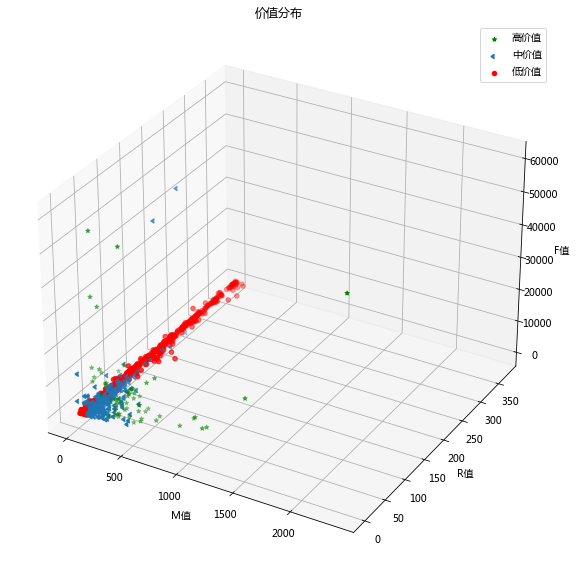

In [32]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_user.query("总体价值 == '高价值'")['F值'],
           df_user.query("总体价值 == '高价值'")['R值'],
           df_user.query("总体价值 == '高价值'")['M值'], c='g', marker='*', label='高价值')
ax.scatter(df_user.query("总体价值 == '中价值'")['F值'],
           df_user.query("总体价值 == '中价值'")['R值'],
           df_user.query("总体价值 == '中价值'")['M值'], marker=8, label='中价值')
ax.scatter(df_user.query("总体价值 == '低价值'")['F值'],
           df_user.query("总体价值 == '低价值'")['R值'],
           df_user.query("总体价值 == '低价值'")['M值'], c='r', label='低价值')

ax.set_zlabel('F值')
ax.set_ylabel('R值')
ax.set_xlabel('M值')
plt.title('价值分布')
plt.legend()

---
## 评估模型

这是无监督学习，不需要进一步评估模型


## 思考题

能不能试着把 R、F、M 三个特征同时输入 K-Means 算法，为用户整体做聚类呢？

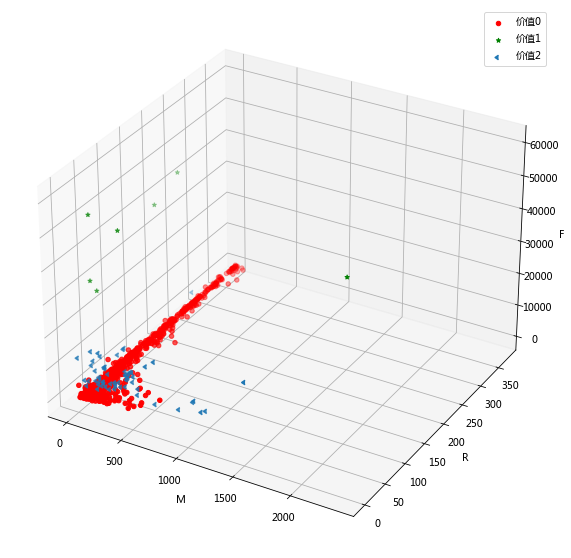

In [33]:
df_user['三维价值'] = KMeans(n_clusters=3)\
    .fit(df_user[['R值', 'F值', 'M值']])\
    .predict(df_user[['R值', 'F值', 'M值']])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_user.query("三维价值 == 0")['F值'],
           df_user.query("三维价值 == 0")['R值'],
           df_user.query("三维价值 == 0")['M值'], c='r', label='价值0')
ax.scatter(df_user.query("三维价值 == 1")['F值'],
           df_user.query("三维价值 == 1")['R值'],
           df_user.query("三维价值 == 1")['M值'], c='g', marker='*', label='价值1')
ax.scatter(df_user.query("三维价值 == 2")['F值'],
           df_user.query("三维价值 == 2")['R值'],
           df_user.query("三维价值 == 2")['M值'], marker=8, label='价值2')

ax.set_zlabel('F')
ax.set_ylabel('R')
ax.set_xlabel('M')
ax.legend()
plt.show()


In [34]:
df_user.head(30)

,用户码,R值,F值,M值,R值层级,F值层级,M值层级,总分,总体价值,三维价值
0,14681,70,7,498.95,2,0,0,2,低价值,0
1,14682,187,2,52.00,1,0,0,1,低价值,0
2,14684,25,390,1201.51,2,2,0,4,中价值,0
3,14687,106,15,628.38,1,0,0,1,低价值,0
4,14688,7,324,5579.10,2,2,1,5,高价值,2
5,14689,208,13,112.80,1,0,0,1,低价值,0
6,14690,43,48,355.05,2,0,0,2,低价值,0
7,14691,30,71,2114.33,2,0,1,3,中价值,0
8,14692,136,68,591.55,1,0,0,1,低价值,0
9,14693,263,8,172.90,0,0,0,0,低价值,0
